In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# %load ../frac_diff.py
import numpy as np
import pandas as pd
from scipy import interp
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller


def getWeights(d, size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 

    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def getWeights_FFD(d, thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 

    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)


def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.

    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    # 2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            # must resample if duplicate index
            test_val = series.loc[loc, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue  # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):, :].T,
                                      seriesF.loc[:loc])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def fracDiff_FFD(series, d, thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.

    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d, thres)  # Constant width window (new solution)
    width = len(w)-1
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            # must resample if duplicate index
            test_val = series.loc[loc1, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue  # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def compute_multiple_ffd(close, threshold, dd):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.

    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.
    '''
    out = pd.DataFrame(
        columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = close
    for d in dd:
        # downcast to daily obs. Dropped NAs
        df1 = np.log(df0).resample('1D').last().dropna()
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + \
            [corr]  # with critical value
    return out


def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.

    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()


In [3]:
GLASSNODE_CSV = '../../datasets/glassnode/csv/dataset.csv'

def unix_time_to_date(x): return pd.to_datetime(x, unit='s')
df = pd.read_csv(GLASSNODE_CSV, parse_dates=['Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')

In [4]:
df.columns

Index(['new-addresses', 'utx-os-created', 'transaction-size-total',
       'transaction-rate', 'total-addresses', 'circulating-supply',
       'utxo-value-spent-mean', 'utxo-value-spent-total', 'sopr',
       'transaction-size-mean', 'block-interval-mean', 'sending-addresses',
       'utxo-value-created-total', 'transfer-volume-median', 'blocks-mined',
       'active-addresses', 'market-cap', 'receiving-addresses',
       'utxo-value-spent-median', 'fees-total', 'daysTillHalving', 'ratio',
       'block-interval-median', 'utx-os-spent', 'block-size-mean',
       'utxo-value-created-mean', 'transfer-volume-total', 'fees-mean',
       'transfer-volume-mean', 'transaction-count', 'price-drawdown-from-ath',
       'block-size-total'],
      dtype='object')

# Addresses

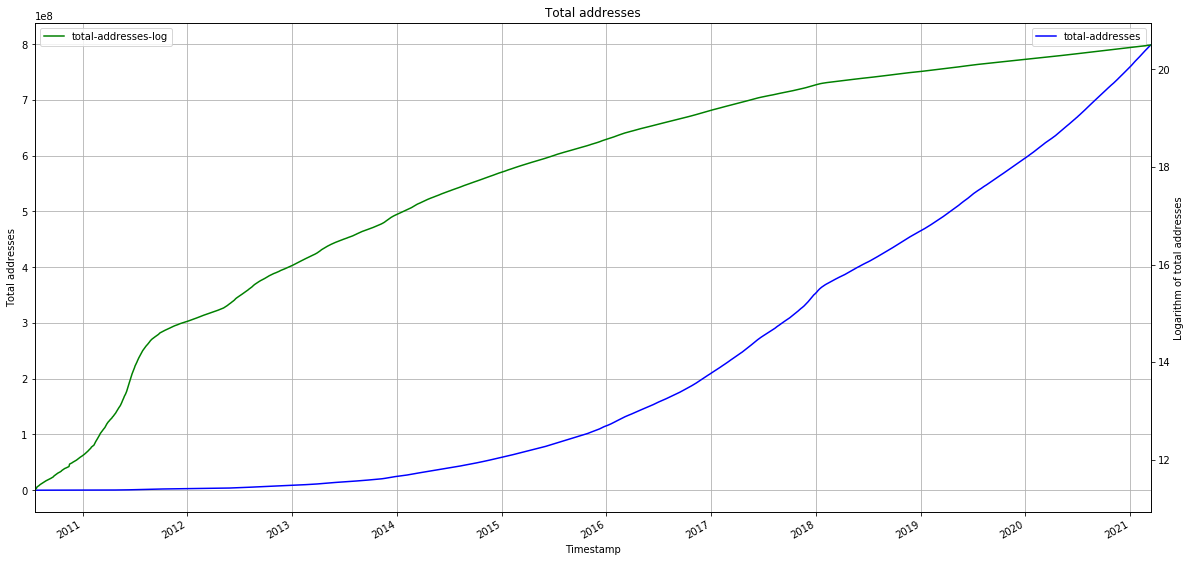

In [151]:
df['total-addresses-log'] = np.log(df['total-addresses'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='total-addresses', color='blue', ax=ax)
ax_right = ax.twinx()
df.plot(kind='line',y='total-addresses-log', color='green', ax=ax_right)
plt.title('Total addresses')
ax.set_ylabel('Total addresses')
ax_right.set_ylabel('Logarithm of total addresses')
ax.grid()
plt.show()

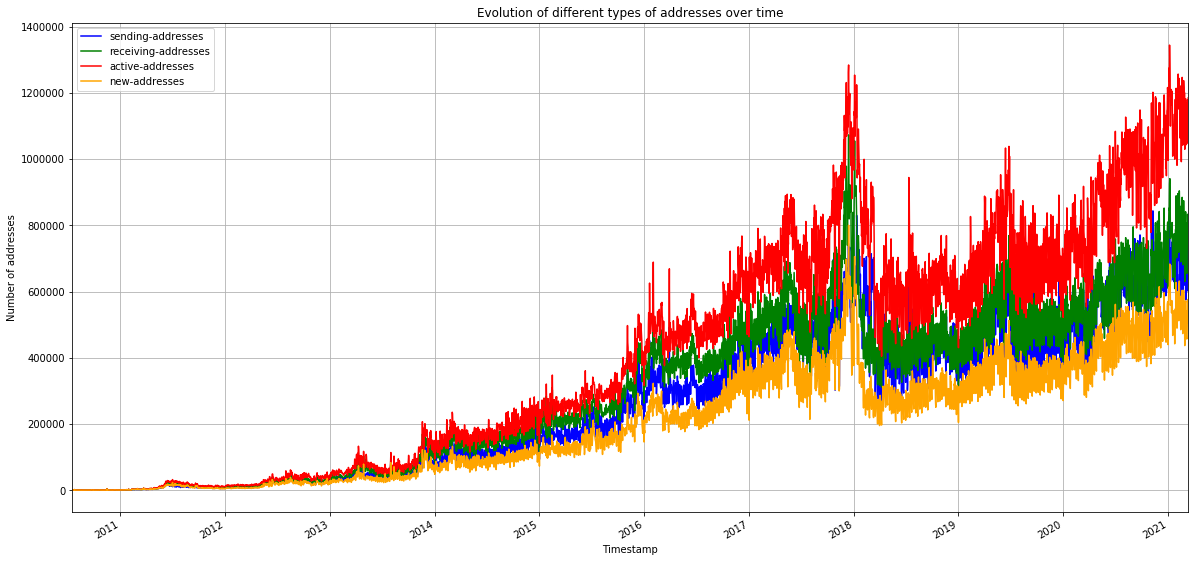

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='sending-addresses', color='blue', ax=ax)
df.plot(kind='line',y='receiving-addresses', color='green', ax=ax)
df.plot(kind='line',y='active-addresses', color='red', ax=ax)
df.plot(kind='line',y='new-addresses', color='orange', ax=ax)
plt.title('Evolution of different types of addresses over time')
plt.ylabel('Number of addresses')
plt.grid()
plt.show()

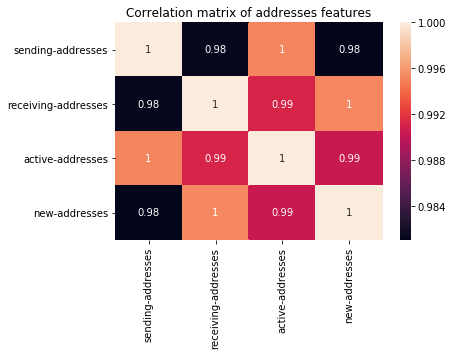

In [169]:
# Shows a correlation matrix
aux = df.loc[:, ['sending-addresses', 'receiving-addresses', 'active-addresses','new-addresses']]
correlation_mat = aux.corr()
ax = sns.heatmap(correlation_mat, annot = True)
plt.title("Correlation matrix of addresses features")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [15]:
# sending-addresses
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['sending-addresses'].to_frame().rename(columns={'sending-addresses':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -3.030471  3.214515e-02   1.0  3890.0 -2.862283  1.000000
0.1  -4.267846  5.047439e-04   1.0  3829.0 -2.862295  0.998464
0.2  -6.644225  5.315429e-09   1.0  3818.0 -2.862297  0.987997
0.3 -10.866219  1.405309e-19   1.0  3825.0 -2.862296  0.954715
0.4 -17.203051  6.441027e-30   1.0  3836.0 -2.862294  0.877594
0.5 -25.333532  0.000000e+00   1.0  3847.0 -2.862292  0.746423
0.6 -34.471505  0.000000e+00   1.0  3857.0 -2.862290  0.582520
0.7 -44.030438  0.000000e+00   1.0  3865.0 -2.862288  0.413274
0.8 -51.242793  0.000000e+00   1.0  3873.0 -2.862287  0.284724
0.9 -57.314176  0.000000e+00   1.0  3879.0 -2.862285  0.171904
1.0 -60.780922  0.000000e+00   1.0  3889.0 -2.862283  0.036447


0.0

In [16]:
# receiving-addresses
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['receiving-addresses'].to_frame().rename(columns={'receiving-addresses':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -3.102630  2.635917e-02   1.0  3890.0 -2.862283  1.000000
0.1  -4.520969  1.801781e-04   1.0  3829.0 -2.862295  0.998615
0.2  -6.521893  1.037211e-08   1.0  3818.0 -2.862297  0.989179
0.3  -9.965683  2.310454e-17   1.0  3825.0 -2.862296  0.958704
0.4 -15.945553  7.456591e-29   1.0  3836.0 -2.862294  0.889074
0.5 -23.546558  0.000000e+00   1.0  3847.0 -2.862292  0.765891
0.6 -32.442506  0.000000e+00   1.0  3857.0 -2.862290  0.606406
0.7 -42.544341  0.000000e+00   1.0  3865.0 -2.862288  0.430476
0.8 -50.475299  0.000000e+00   1.0  3873.0 -2.862287  0.294739
0.9 -56.846603  0.000000e+00   1.0  3879.0 -2.862285  0.175978
1.0 -61.334503  0.000000e+00   1.0  3889.0 -2.862283  0.030345


0.0

In [17]:
# active-addresses
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['active-addresses'].to_frame().rename(columns={'active-addresses':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -2.826657  5.456575e-02   1.0  3890.0 -2.862283  1.000000
0.1  -3.819325  2.715670e-03   1.0  3829.0 -2.862295  0.998824
0.2  -5.678218  8.606044e-07   1.0  3818.0 -2.862297  0.990737
0.3  -9.260122  1.414497e-15   1.0  3825.0 -2.862296  0.964890
0.4 -14.805416  2.068800e-27   1.0  3836.0 -2.862294  0.902722
0.5 -22.147029  0.000000e+00   1.0  3847.0 -2.862292  0.788266
0.6 -31.002848  0.000000e+00   1.0  3857.0 -2.862290  0.631159
0.7 -41.082642  0.000000e+00   1.0  3865.0 -2.862288  0.453671
0.8 -49.389821  0.000000e+00   1.0  3873.0 -2.862287  0.312159
0.9 -56.650098  0.000000e+00   1.0  3879.0 -2.862285  0.184050
1.0 -60.934795  0.000000e+00   1.0  3889.0 -2.862283  0.027890


0.1

In [18]:
# new-addresses
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['new-addresses'].to_frame().rename(columns={'new-addresses':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -3.099264  2.660768e-02   1.0  3890.0 -2.862283  1.000000
0.1  -4.549445  1.599121e-04   1.0  3829.0 -2.862295  0.998421
0.2  -7.011703  6.895055e-10   1.0  3818.0 -2.862297  0.987714
0.3 -10.883814  1.274909e-19   1.0  3825.0 -2.862296  0.954453
0.4 -17.042728  8.174493e-30   1.0  3836.0 -2.862294  0.880040
0.5 -24.869787  0.000000e+00   1.0  3847.0 -2.862292  0.753348
0.6 -33.771752  0.000000e+00   1.0  3857.0 -2.862290  0.592353
0.7 -42.889767  0.000000e+00   1.0  3865.0 -2.862288  0.424645
0.8 -50.046445  0.000000e+00   1.0  3873.0 -2.862287  0.294232
0.9 -55.890595  0.000000e+00   1.0  3879.0 -2.862285  0.175834
1.0 -59.880595  0.000000e+00   1.0  3889.0 -2.862283  0.033435


0.0

In [19]:
# total-addresses
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['total-addresses'].to_frame().rename(columns={'total-addresses':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0 -10.938653  9.417961e-20   1.0  3890.0 -2.862283  1.000000
0.1 -14.403547  8.430648e-27   1.0  3829.0 -2.862295  0.999989
0.2 -16.680388  1.518151e-29   1.0  3818.0 -2.862297  0.999925
0.3 -16.349491  2.942019e-29   1.0  3825.0 -2.862296  0.999815
0.4 -14.023816  3.532518e-26   1.0  3836.0 -2.862294  0.999680
0.5 -10.713042  3.294350e-19   1.0  3847.0 -2.862292  0.999529
0.6  -7.717595  1.216529e-11   1.0  3857.0 -2.862290  0.999356
0.7  -5.385678  3.629886e-06   1.0  3865.0 -2.862288  0.999072
0.8  -3.783836  3.077094e-03   1.0  3873.0 -2.862287  0.998678
0.9  -2.687926  7.615097e-02   1.0  3879.0 -2.862285  0.996941
1.0  -9.098751  3.654021e-15   1.0  3889.0 -2.862283 -0.687748


0.8

In [20]:
df['sending-addresses_FFD'] = fracDiff_FFD(df['sending-addresses'].to_frame(), d=0.05, thres=1e-3)
df['receiving-addresses_FFD'] = fracDiff_FFD(df['receiving-addresses'].to_frame(), d=0.05, thres=1e-3)
df['active-addresses_FFD'] = fracDiff_FFD(df['active-addresses'].to_frame(), d=0.1, thres=1e-3)
df['new-addresses_FFD'] = fracDiff_FFD(df['new-addresses'].to_frame(), d=0.05, thres=1e-3)
df['total-addresses_FFD'] = fracDiff_FFD(df['total-addresses'].to_frame(), d=0.85, thres=1e-3)

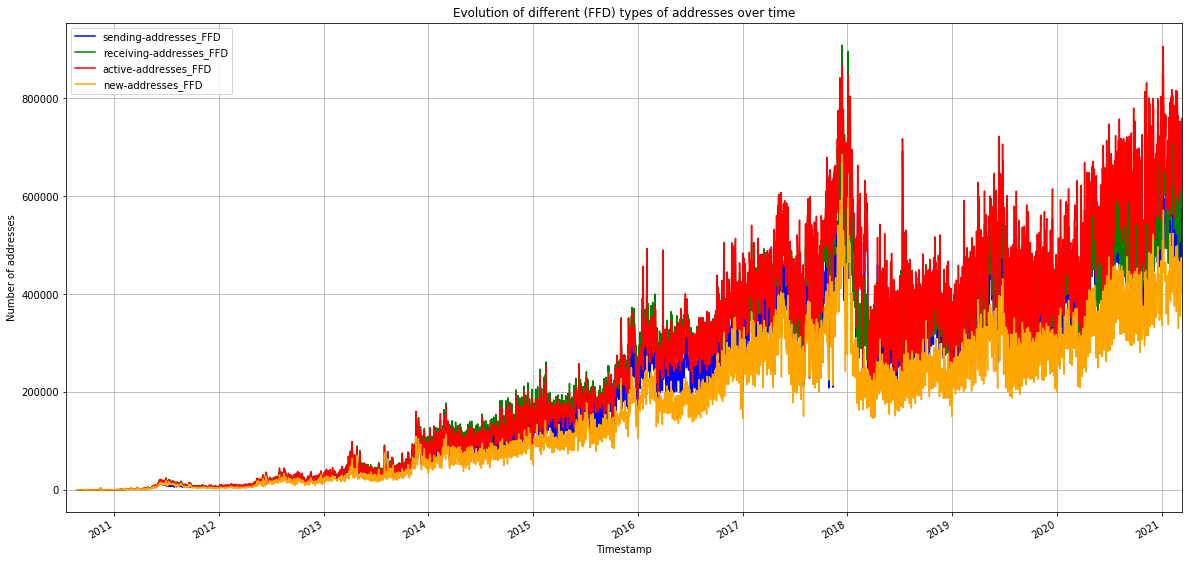

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='sending-addresses_FFD', color='blue', ax=ax)
df.plot(kind='line',y='receiving-addresses_FFD', color='green', ax=ax)
df.plot(kind='line',y='active-addresses_FFD', color='red', ax=ax)
df.plot(kind='line',y='new-addresses_FFD', color='orange', ax=ax)
plt.title('Evolution of different (FFD) types of addresses over time')
plt.ylabel('Number of addresses')
plt.grid()
plt.show()

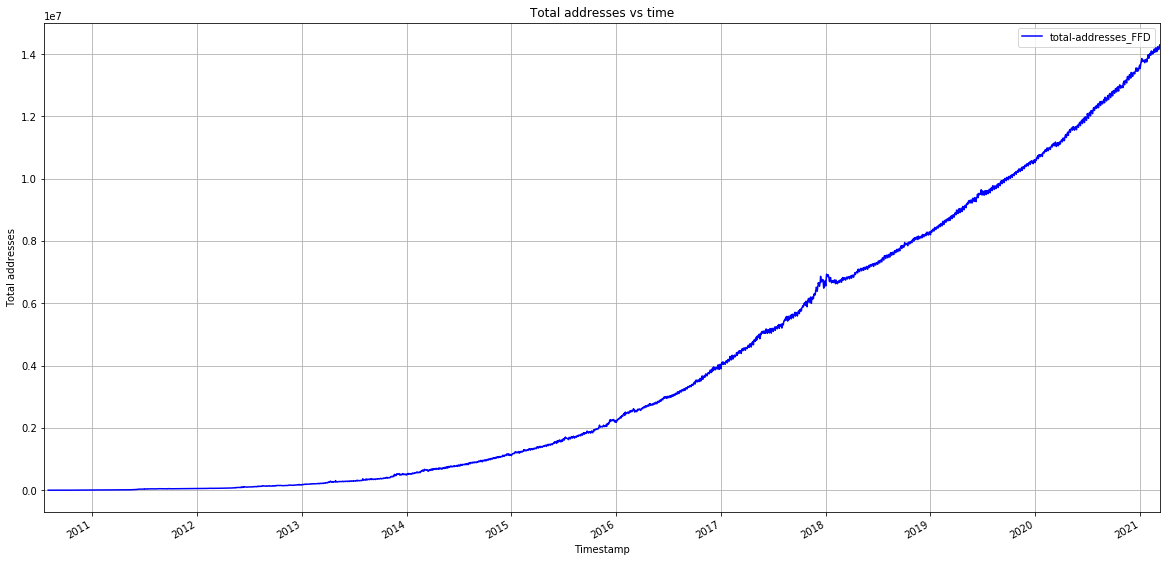

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='total-addresses_FFD', color='blue', ax=ax)
plt.title('Total addresses vs time')
plt.ylabel('Total addresses')
plt.grid()
plt.show()

In [23]:
df['total-addresses-log'] = np.log(df['total-addresses'])

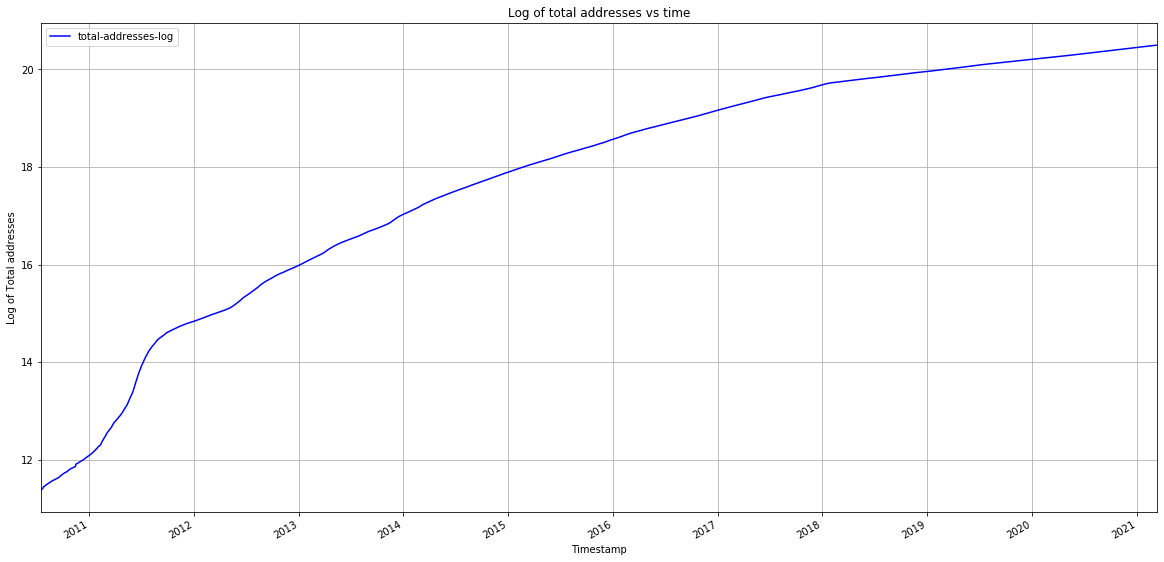

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='total-addresses-log', color='blue', ax=ax)
plt.title('Log of total addresses vs time')
plt.ylabel('Log of Total addresses')
plt.grid()
plt.show()

# Blocks

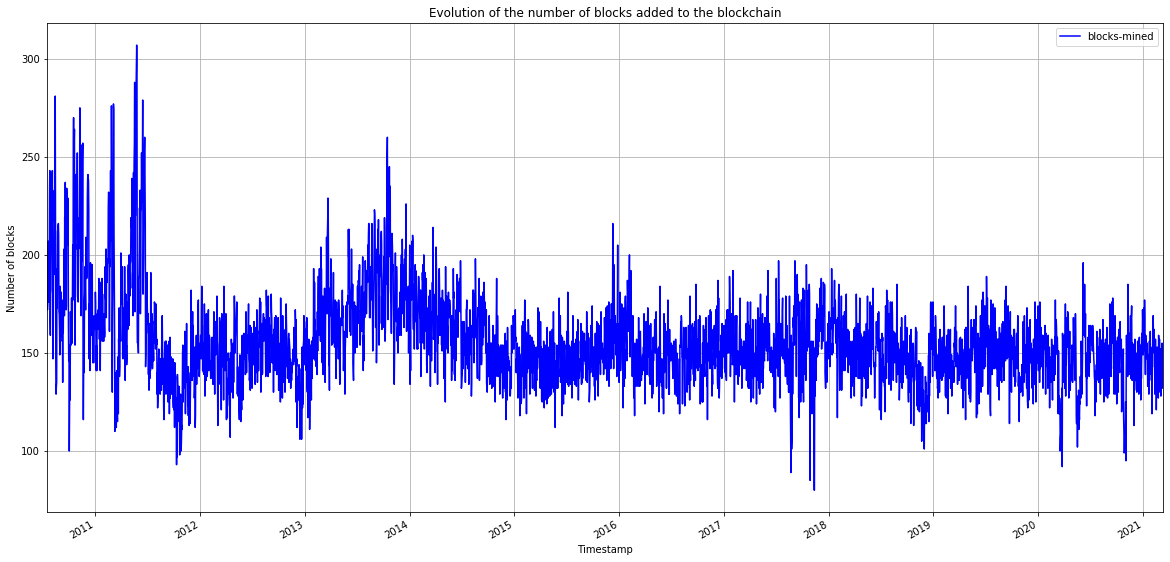

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='blocks-mined', color='blue', ax=ax)
plt.title('Evolution of the number of blocks added to the blockchain')
plt.ylabel('Number of blocks')
plt.grid()
plt.show()

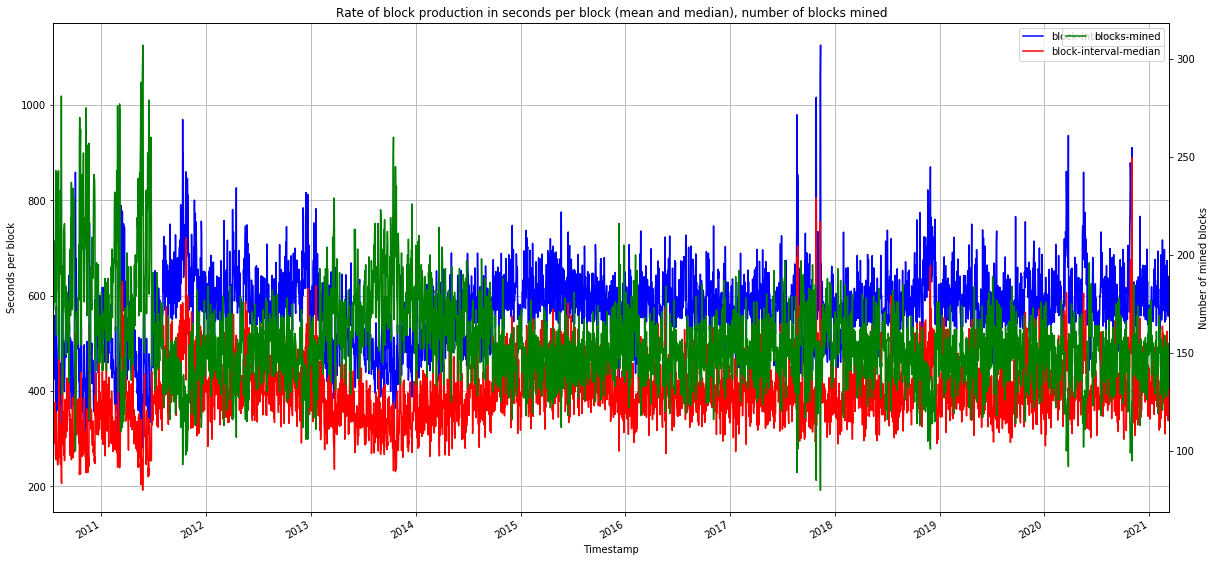

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='block-interval-mean', color='blue', ax=ax)
df.plot(kind='line',y='block-interval-median', color='red', ax=ax)
ax_right = ax.twinx()
df.plot(kind='line',y='blocks-mined', color='green', ax=ax_right)
plt.title('Rate of block production in seconds per block (mean and median), number of blocks mined')
ax.set_ylabel('Seconds per block')
ax_right.set_ylabel('Number of mined blocks')
ax.grid()
plt.show()

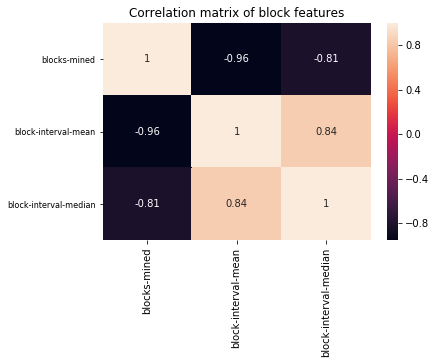

In [171]:
# Shows a correlation matrix
aux = df.loc[:, ['blocks-mined', 'block-interval-mean', 'block-interval-median']]
correlation_mat = aux.corr()
ax = sns.heatmap(correlation_mat, annot = True)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
plt.title("Correlation matrix of block features")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

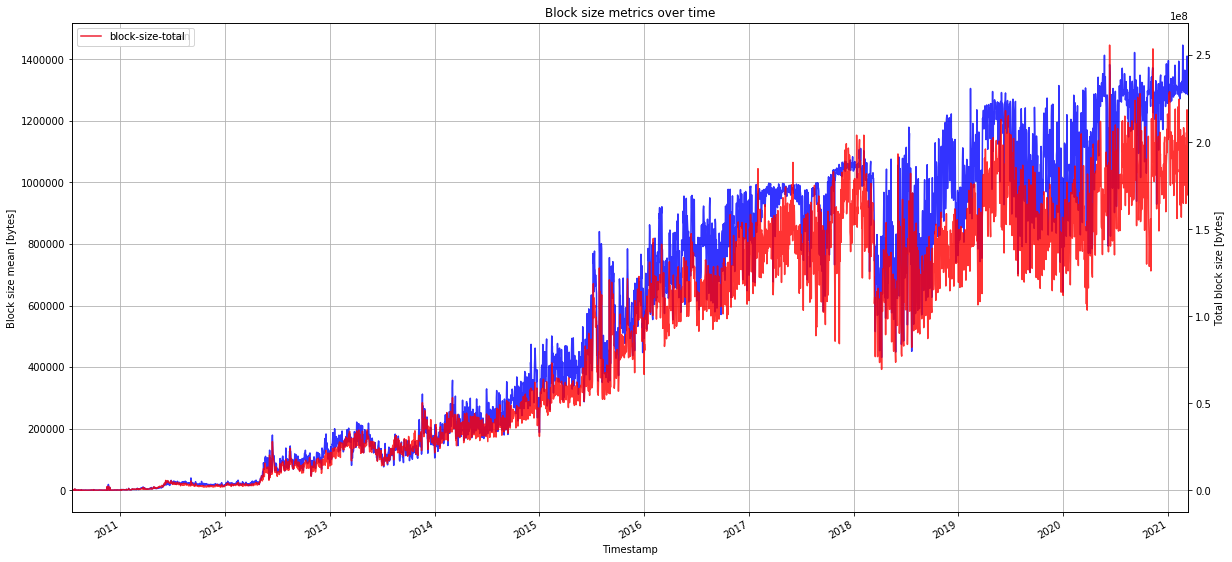

In [188]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='block-size-mean', color='blue', alpha=0.8, ax=ax)
ax_right = ax.twinx()
df.plot(kind='line',y='block-size-total', color='red', alpha=0.8, ax=ax_right)
plt.title('Block size metrics over time')
ax.set_ylabel('Block size mean [bytes]')
ax_right.set_ylabel('Total block size [bytes]')
ax.grid()
plt.show()

In [34]:
# block-size-mean
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['block-size-mean'].to_frame().rename(columns={'block-size-mean':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -3.536162  7.105520e-03   1.0  3890.0 -2.862283  1.000000
0.1  -5.244368  7.132077e-06   1.0  3829.0 -2.862295  0.997906
0.2  -8.239891  5.754982e-13   1.0  3818.0 -2.862297  0.983648
0.3 -13.163142  1.295033e-24   1.0  3825.0 -2.862296  0.940269
0.4 -20.464337  0.000000e+00   1.0  3836.0 -2.862294  0.848387
0.5 -29.501207  0.000000e+00   1.0  3847.0 -2.862292  0.704965
0.6 -39.375371  0.000000e+00   1.0  3857.0 -2.862290  0.542981
0.7 -48.942508  0.000000e+00   1.0  3865.0 -2.862288  0.381583
0.8 -55.996640  0.000000e+00   1.0  3873.0 -2.862287  0.263333
0.9 -61.750889  0.000000e+00   1.0  3879.0 -2.862285  0.161913
1.0 -66.343067  0.000000e+00   1.0  3889.0 -2.862283  0.042709


0.0

In [35]:
# block-size-mean
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['block-size-total'].to_frame().rename(columns={'block-size-total':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -3.431797  9.921509e-03   1.0  3890.0 -2.862283  1.000000
0.1  -4.952350  2.755219e-05   1.0  3829.0 -2.862295  0.998064
0.2  -7.767573  9.101281e-12   1.0  3818.0 -2.862297  0.984802
0.3 -12.469424  3.269949e-23   1.0  3825.0 -2.862296  0.944193
0.4 -19.486992  0.000000e+00   1.0  3836.0 -2.862294  0.856259
0.5 -28.355782  0.000000e+00   1.0  3847.0 -2.862292  0.716020
0.6 -38.083532  0.000000e+00   1.0  3857.0 -2.862290  0.552182
0.7 -47.653955  0.000000e+00   1.0  3865.0 -2.862288  0.388958
0.8 -54.887710  0.000000e+00   1.0  3873.0 -2.862287  0.268526
0.9 -61.050108  0.000000e+00   1.0  3879.0 -2.862285  0.162926
1.0 -65.739422  0.000000e+00   1.0  3889.0 -2.862283  0.041270


0.0

In [36]:
df['block-size-mean_FFD'] = fracDiff_FFD(df['block-size-mean'].to_frame(), d=0.05, thres=1e-3)
df['block-size-total_FFD'] = fracDiff_FFD(df['block-size-total'].to_frame(), d=0.05, thres=1e-3)

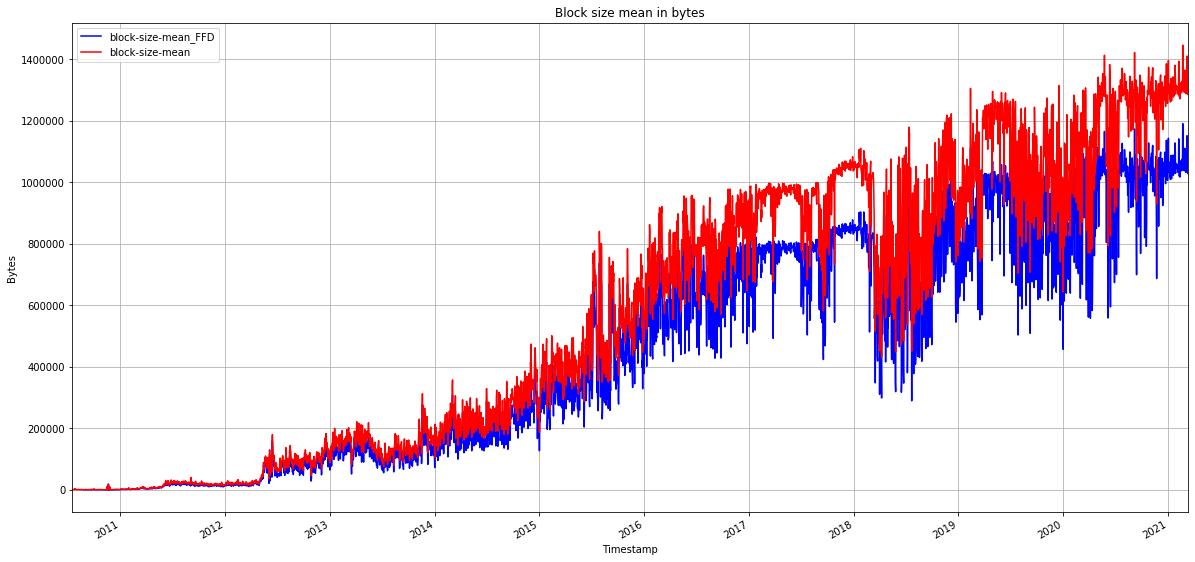

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='block-size-mean_FFD', color='blue', ax=ax)
df.plot(kind='line',y='block-size-mean', color='red', ax=ax)
plt.title('Block size mean in bytes')
plt.ylabel('Bytes')
plt.grid()
plt.show()

In [39]:
df['block-size-mean_log'] = np.log(df['block-size-mean'])
df['block-size-total_log'] = np.log(df['block-size-total'])

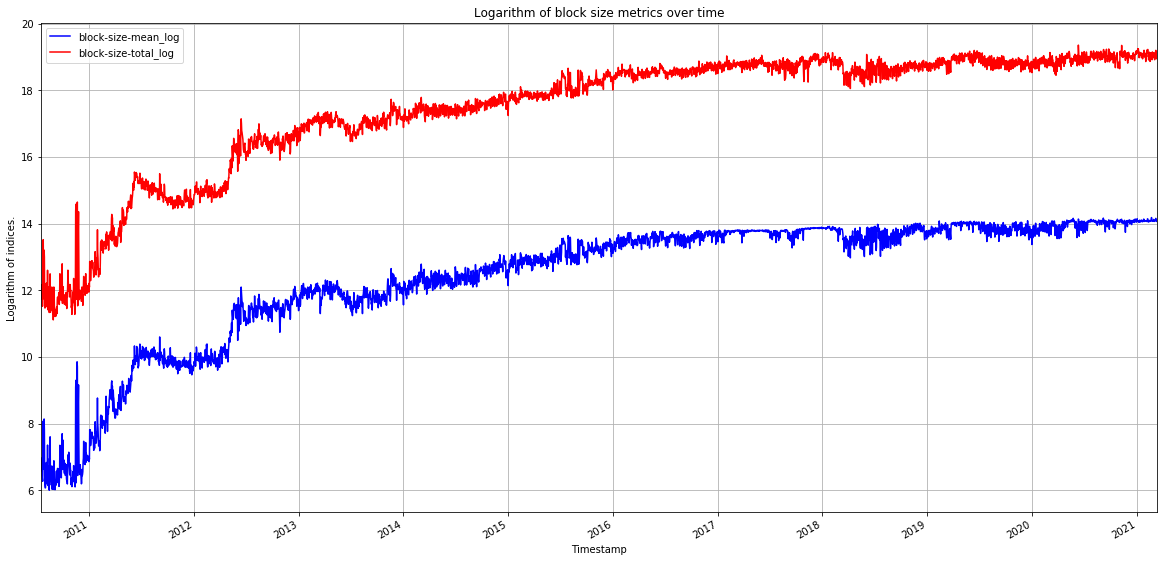

In [187]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='block-size-mean_log', color='blue', ax=ax)
df.plot(kind='line',y='block-size-total_log', color='red', ax=ax)
plt.title('Logarithm of block size metrics over time')
plt.ylabel('Logarithm of indices.')
plt.grid()
plt.show()

# Fees

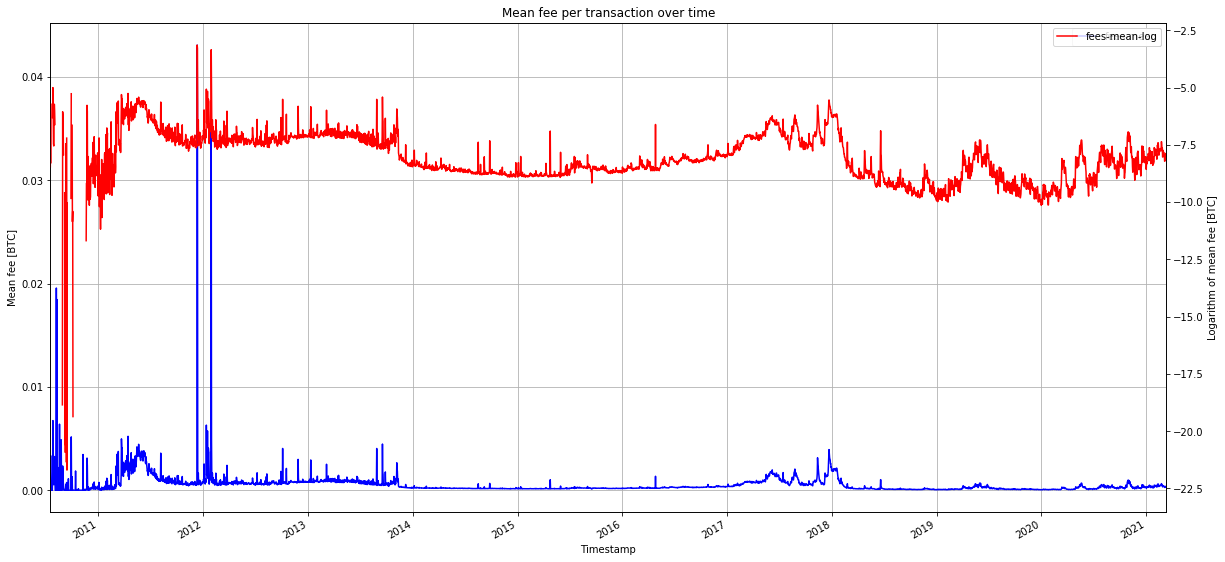

In [203]:
df['fees-mean-log'] = np.log(df['fees-mean'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='fees-mean', color='blue', ax=ax)
ax_right = ax.twinx()
df.plot(kind='line',y='fees-mean-log', color='red', ax=ax_right)

plt.title('Mean fee per transaction over time')

ax.set_ylabel('Mean fee [BTC]')
ax_right.set_ylabel('Logarithm of mean fee [BTC]')

ax.grid()
plt.show()

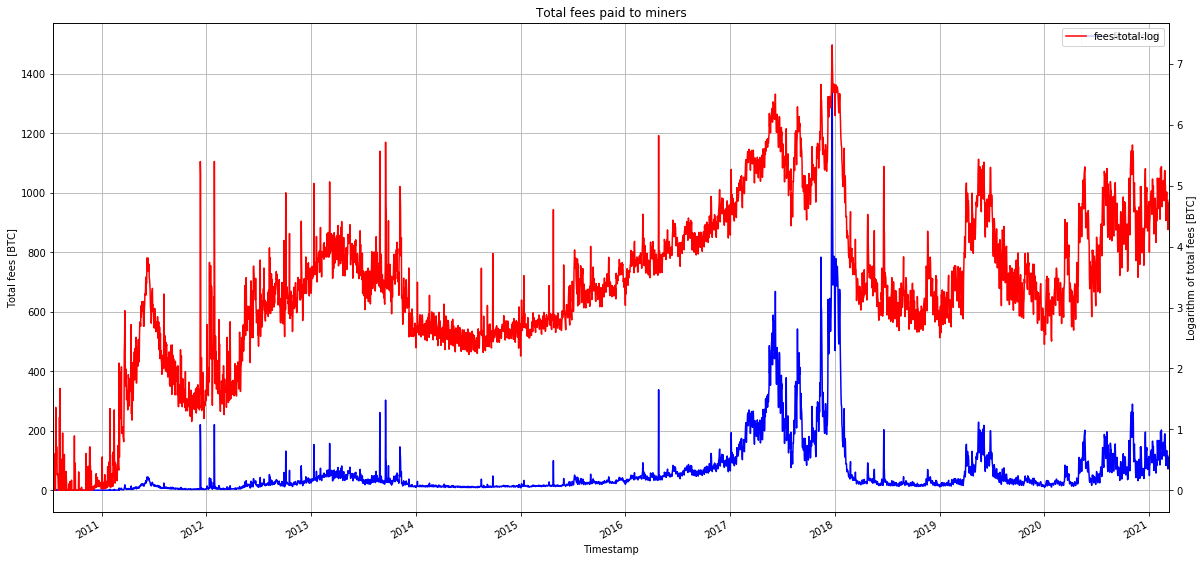

In [195]:
df['fees-total-log'] = np.log(df['fees-total'] + 1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

df.plot(kind='line',y='fees-total', color='blue', ax=ax)
ax_right = ax.twinx()
df.plot(kind='line',y='fees-total-log', color='red', ax=ax_right)

plt.title('Total fees paid to miners')
ax.set_ylabel('Total fees [BTC]')
ax_right.set_ylabel('Logarithm of total fees [BTC]')

ax.grid()
plt.show()

# Indicators

## SOPR

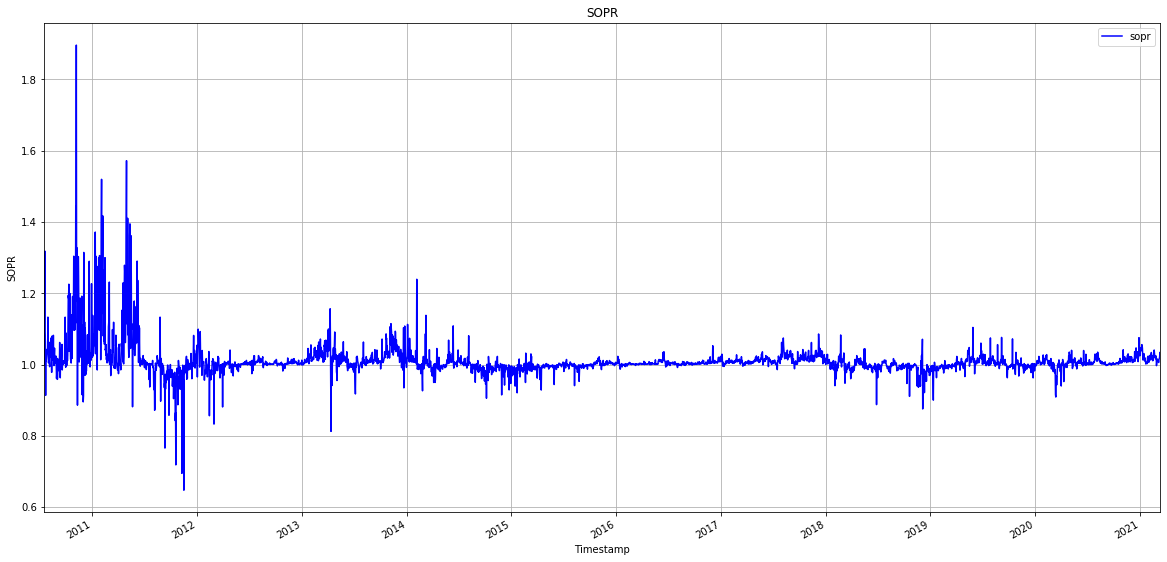

In [207]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='sopr', color='blue', ax=ax)
plt.title('SOPR')
plt.ylabel('SOPR')
plt.grid()
plt.show()

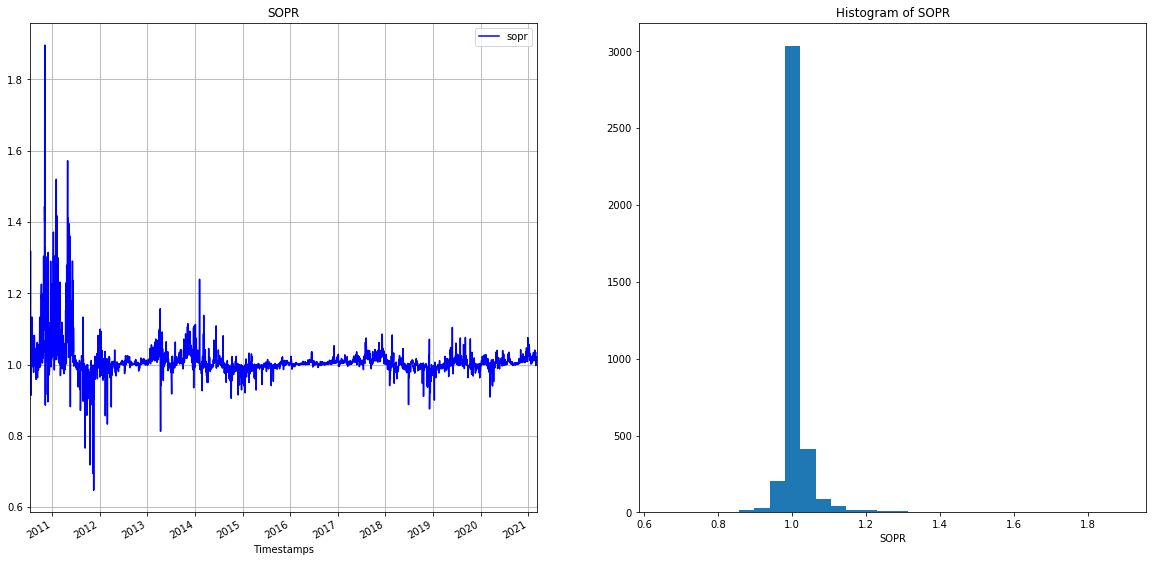

In [51]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
df.plot(kind='line',y='sopr', color='blue', ax=ax[0])
df['sopr'].hist(bins=30, ax=ax[1])

ax[0].set_title('SOPR')
ax[1].set_title('Histogram of SOPR')

ax[0].set_xlabel('Timestamps')
ax[1].set_xlabel('SOPR')

ax[0].grid()
ax[1].grid()

plt.show()

## price-drawdown-from-ath

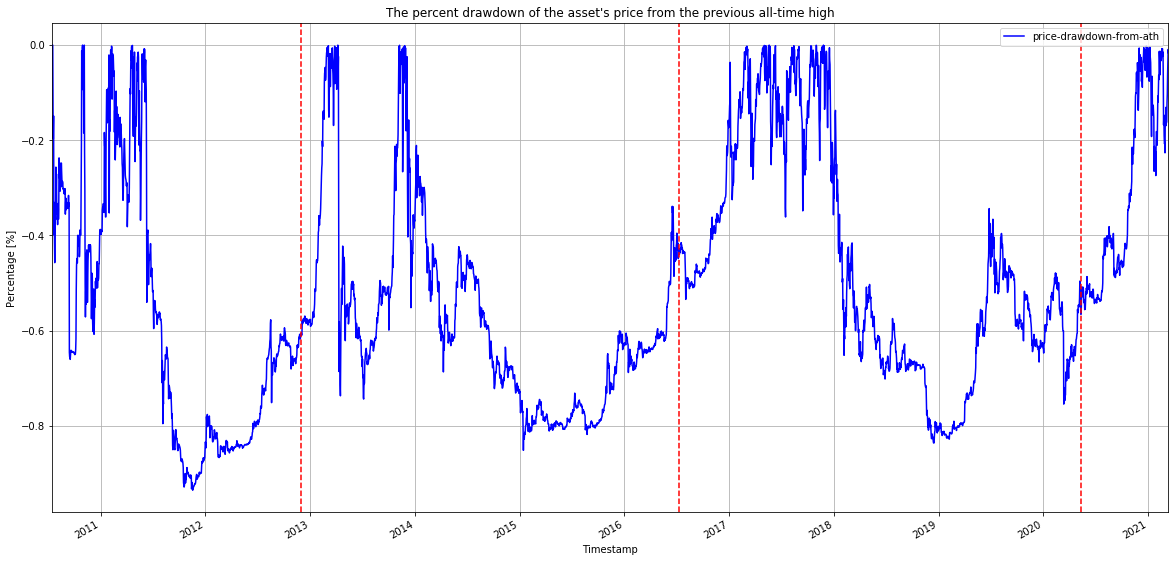

In [204]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='price-drawdown-from-ath', color='blue', ax=ax)
plt.title("The percent drawdown of the asset's price from the previous all-time high")
plt.ylabel('Percentage [%]')
ax.axvline(pd.datetime(year=2012, month=11, day=28), ls='--', color='r')
ax.axvline(pd.datetime(year=2016, month=7, day=9), ls='--', color='r')
ax.axvline(pd.datetime(year=2020, month=5, day=11), ls='--', color='r')
plt.grid()
plt.show()

## market-cap

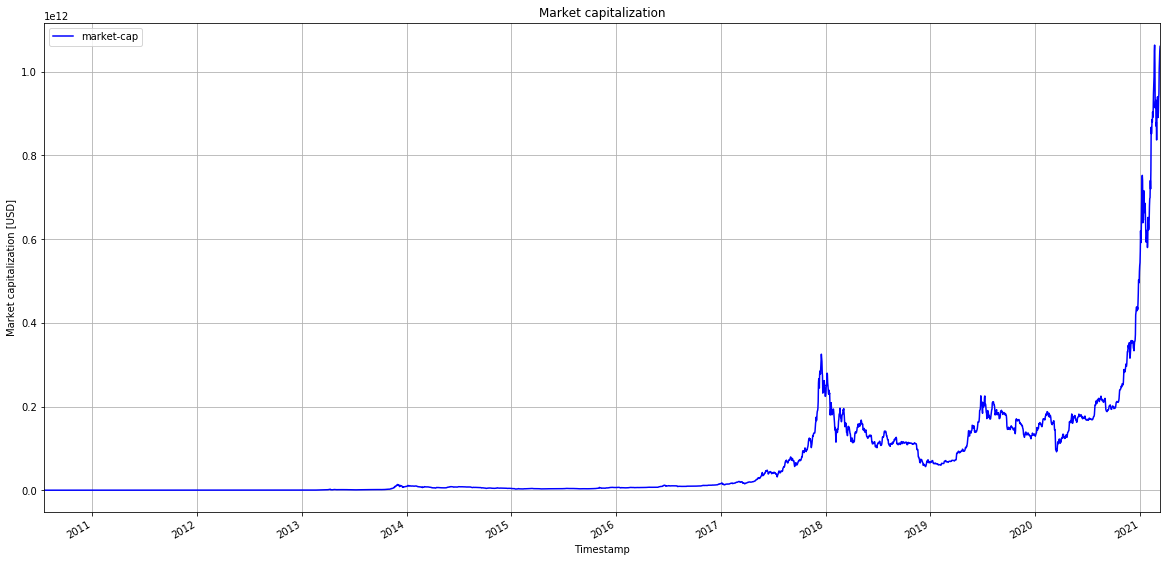

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='market-cap', color='blue', ax=ax)
plt.title("Market capitalization")
plt.ylabel('Market capitalization [USD]')
plt.grid()
plt.show()

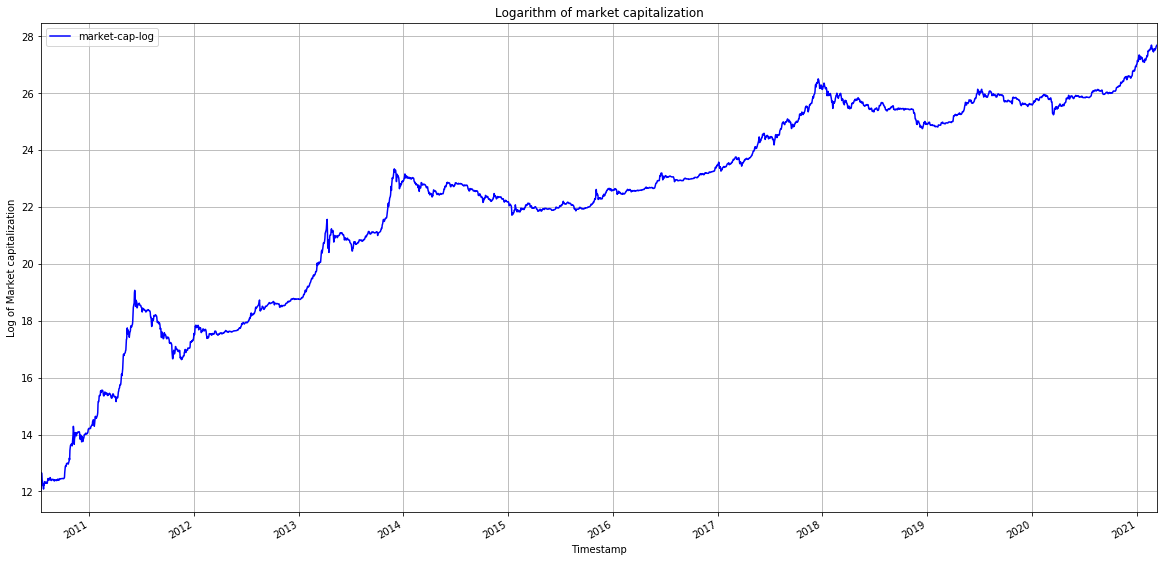

In [56]:
df['market-cap-log'] = np.log(df['market-cap'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='market-cap-log', color='blue', ax=ax)
plt.title("Logarithm of market capitalization")
plt.ylabel('Log of Market capitalization')
plt.grid()
plt.show()

## circulating supply

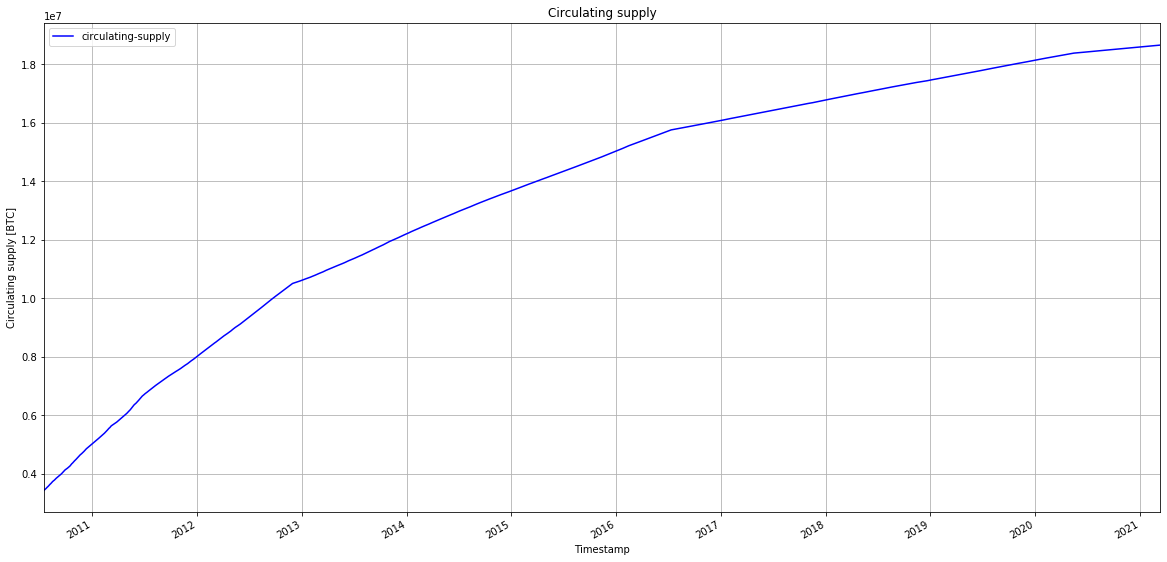

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='circulating-supply', color='blue', ax=ax)
plt.title("Circulating supply")
plt.ylabel('Circulating supply [BTC]')
plt.grid()
plt.show()

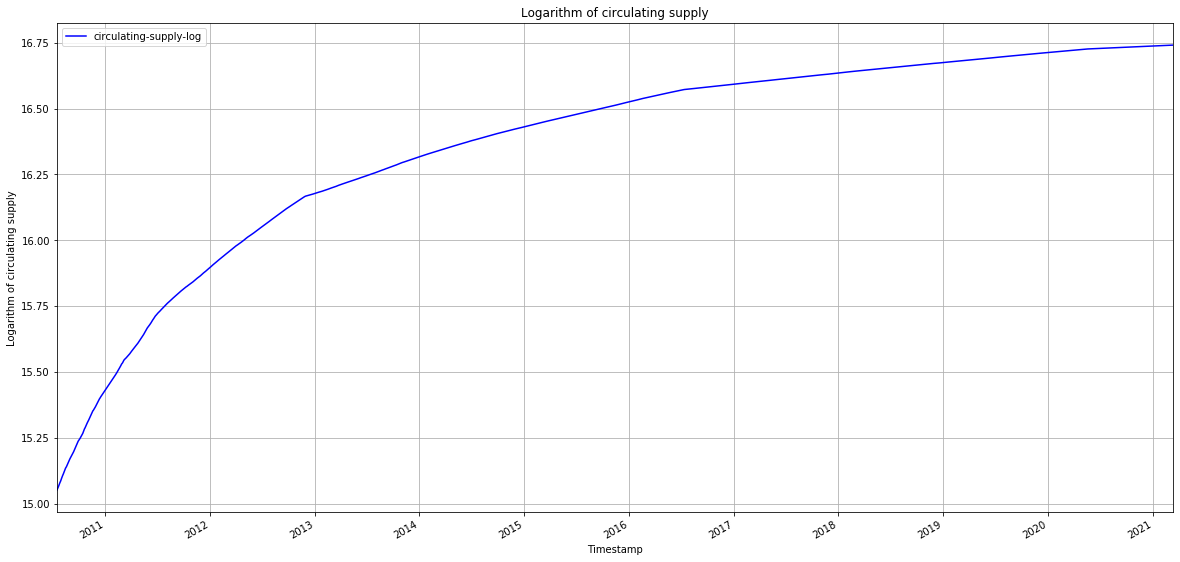

In [58]:
df['circulating-supply-log'] = np.log(df['circulating-supply'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='circulating-supply-log', color='blue', ax=ax)
plt.title("Logarithm of circulating supply")
plt.ylabel('Logarithm of circulating supply')
plt.grid()
plt.show()

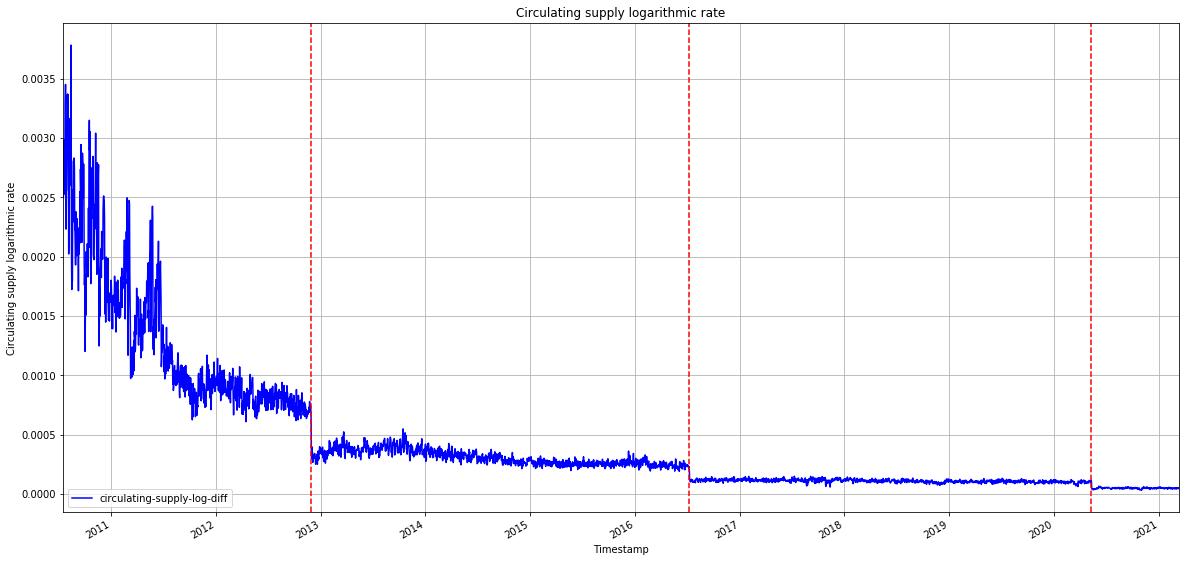

In [205]:
df['circulating-supply-log-diff'] = df['circulating-supply-log'].diff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='circulating-supply-log-diff', color='blue', ax=ax)
plt.title("Circulating supply logarithmic rate")
plt.ylabel("Circulating supply logarithmic rate")
ax.axvline(pd.datetime(year=2012, month=11, day=28), ls='--', color='r')
ax.axvline(pd.datetime(year=2016, month=7, day=9), ls='--', color='r')
ax.axvline(pd.datetime(year=2020, month=5, day=11), ls='--', color='r')
plt.grid()
plt.show()

# Transactions

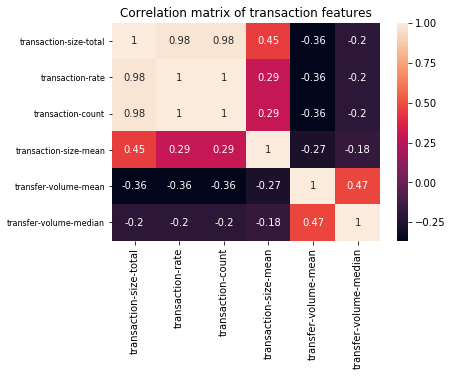

In [209]:
aux = df.loc[:, ['transaction-size-total', 'transaction-rate', 'transaction-count', 'transaction-size-mean', 'transfer-volume-mean', 'transfer-volume-median']]

correlation_mat = aux.corr()
ax = sns.heatmap(correlation_mat, annot = True)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
plt.title("Correlation matrix of transaction features")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

## transaction-size-total

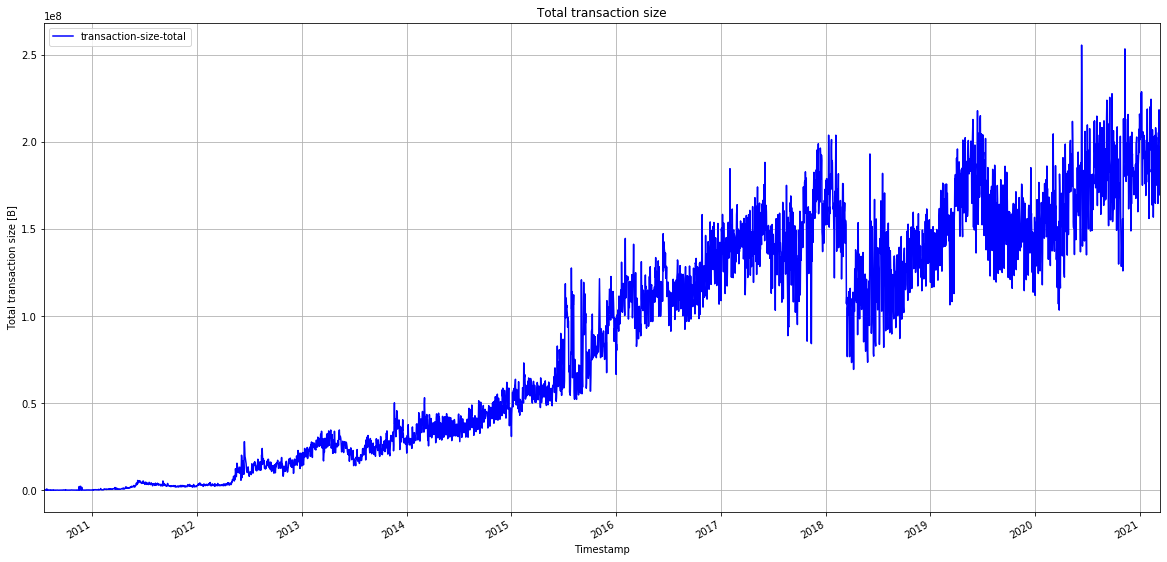

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transaction-size-total', color='blue', ax=ax)
plt.title("Total transaction size")
plt.ylabel("Total transaction size [B]")
plt.grid()
plt.show()

## transaction-rate

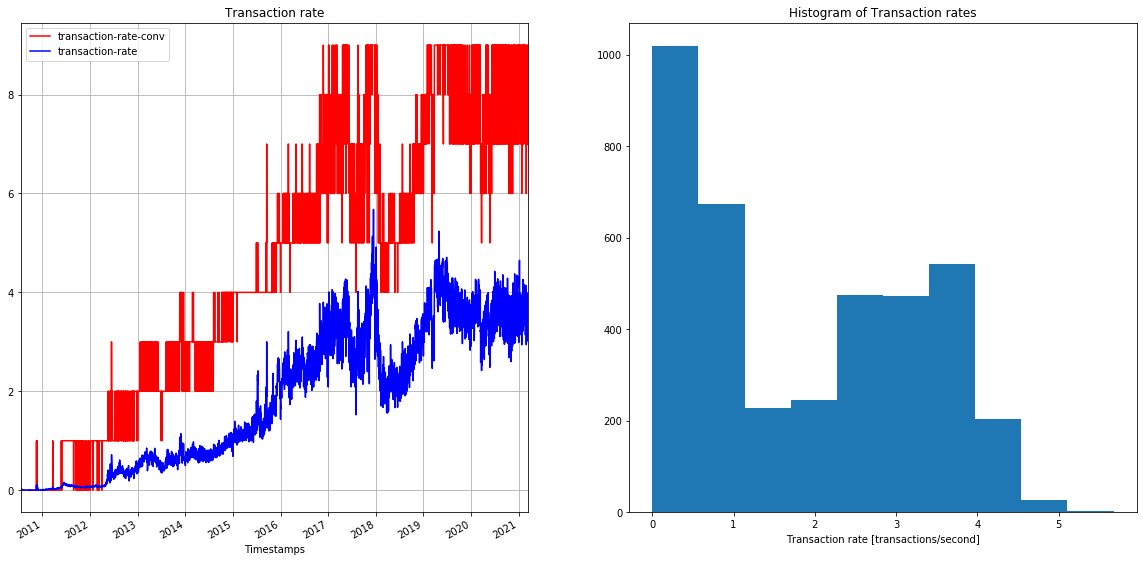

In [210]:
# Ploteamos la series.
df['transaction-rate-conv'] = pd.qcut(df['transaction-rate'], q=10, labels=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

df.plot(kind='line',y='transaction-rate-conv', color='red', ax=ax[0])
df.plot(kind='line',y='transaction-rate', color='blue', ax=ax[0])


df['transaction-rate'].hist(bins=10, ax=ax[1])

ax[0].set_title('Transaction rate')
ax[1].set_title('Histogram of Transaction rates')

ax[0].set_xlabel('Timestamps')
ax[1].set_xlabel('Transaction rate [transactions/second]')

ax[0].grid()
ax[1].grid()

plt.show()

## transaction-count

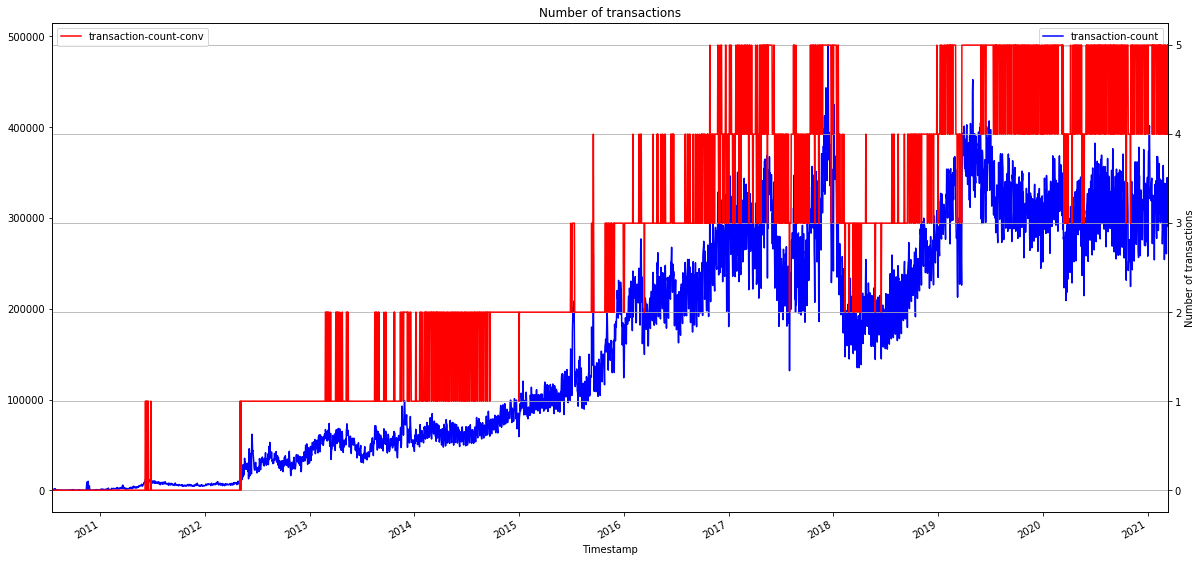

In [126]:
df['transaction-count-conv'] = pd.qcut(df['transaction-count'], q=6, labels=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transaction-count-conv', color='red', ax=ax.twinx())
df.plot(kind='line',y='transaction-count', color='blue', ax=ax)
plt.title("Number of transactions")
plt.ylabel("Number of transactions")
plt.grid()
plt.show()

## transaction-size-mean

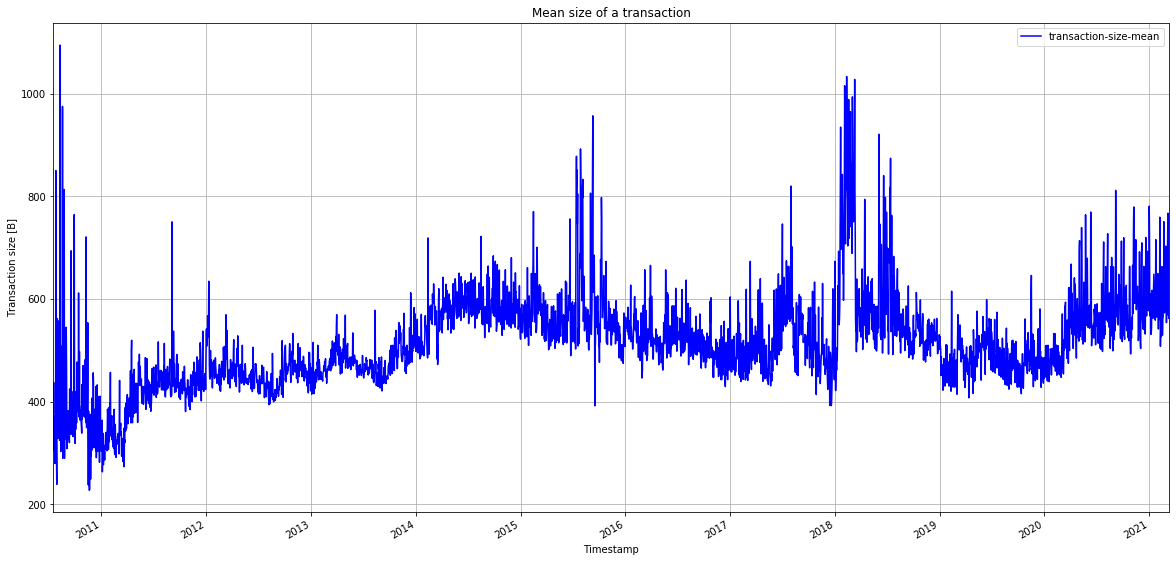

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transaction-size-mean', color='blue', ax=ax)
plt.title("Mean size of a transaction")
plt.ylabel("Transaction size [B]")
plt.grid()
plt.show()

## transfer-volume-mean and transfer-volume-median

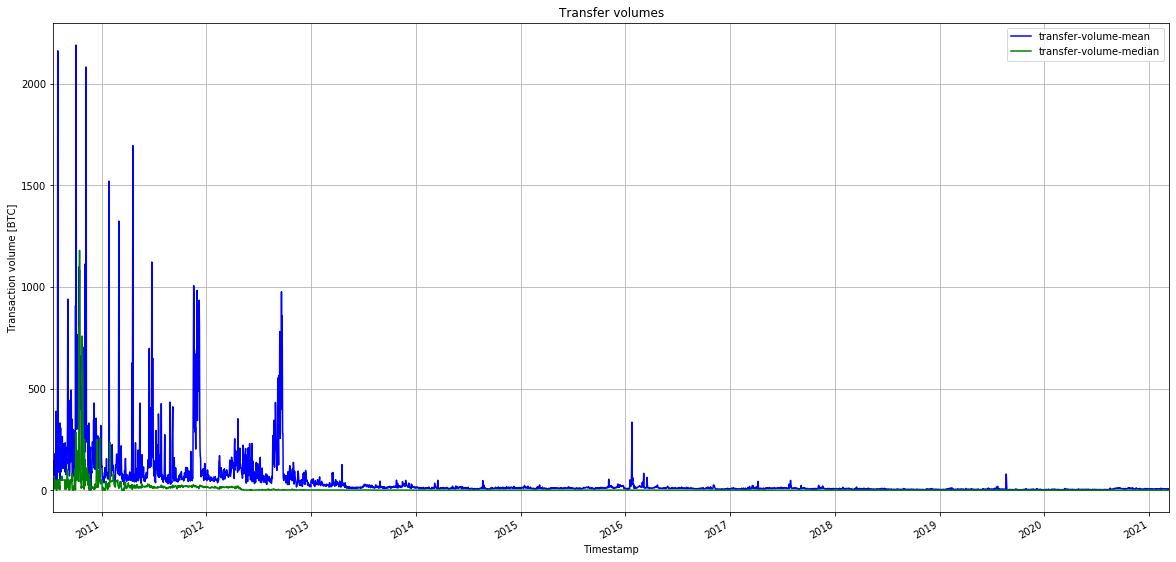

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transfer-volume-mean', color='blue', ax=ax)
df.plot(kind='line',y='transfer-volume-median', color='green', ax=ax)
plt.title("Transfer volumes")
plt.ylabel("Transaction volume [BTC]")
plt.grid()
plt.show()

In [105]:
df['transfer-volume-mean-log'] = np.log(df['transfer-volume-mean'])
df['transfer-volume-median-log'] = np.log(df['transfer-volume-median'])

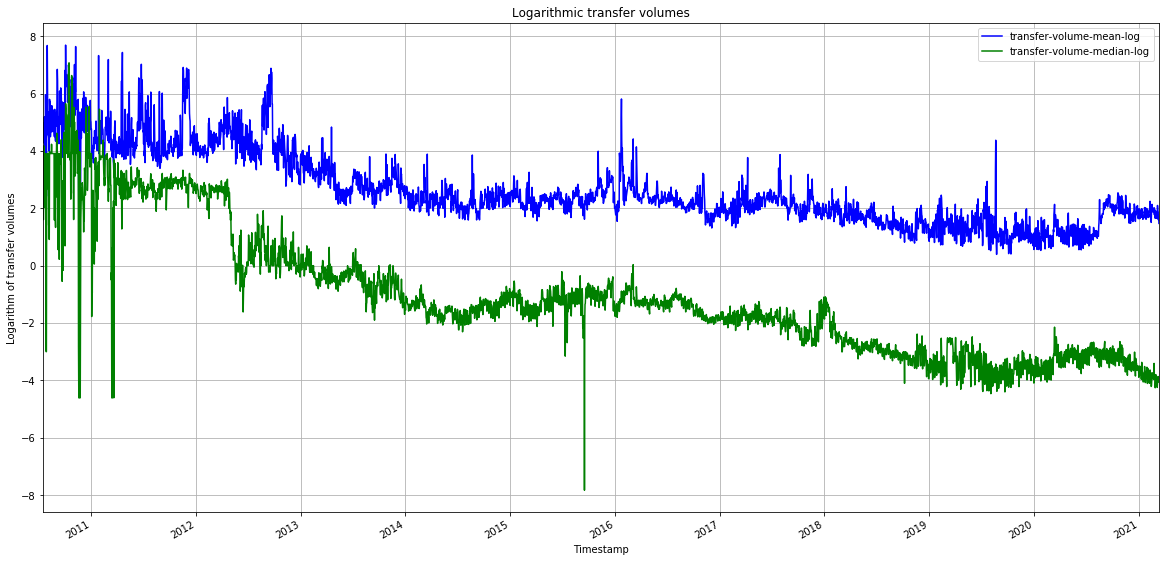

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transfer-volume-mean-log', color='blue', ax=ax)
df.plot(kind='line',y='transfer-volume-median-log', color='green', ax=ax)
plt.title("Logarithmic transfer volumes")
plt.ylabel("Logarithm of transfer volumes")
plt.grid()
plt.show()

## transfer-volume-total

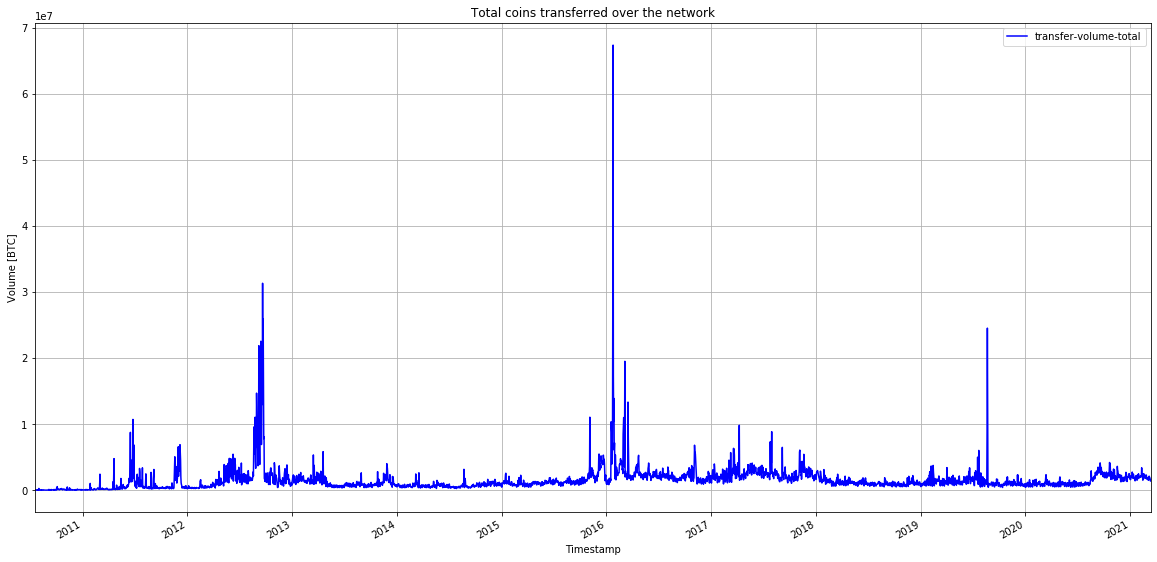

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transfer-volume-total', color='blue', ax=ax)
plt.title("Total coins transferred over the network")
plt.ylabel("Volume [BTC]")
plt.grid()
plt.show()

In [110]:
df['transfer-volume-total-log'] = np.log(df['transfer-volume-total'])

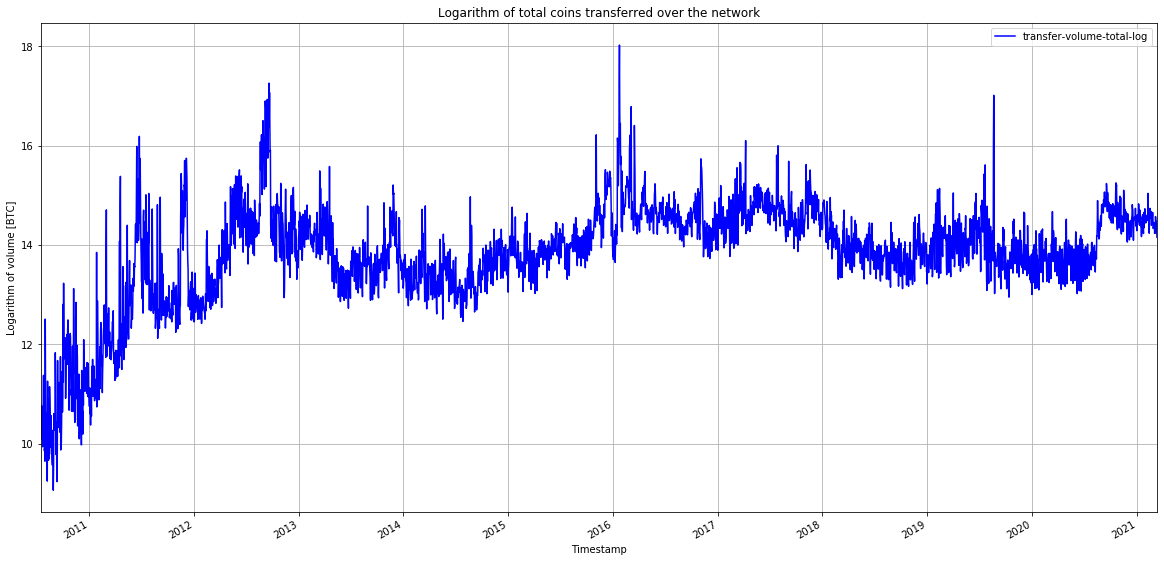

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='transfer-volume-total-log', color='blue', ax=ax)
plt.title("Logarithm of total coins transferred over the network")
plt.ylabel("Logarithm of volume [BTC]")
plt.grid()
plt.show()

# UTXO

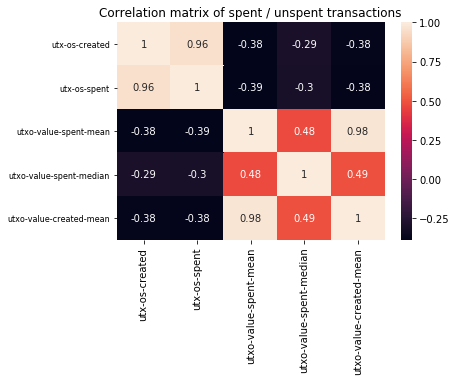

In [212]:
aux = df.loc[:, ['utx-os-created', 'utx-os-spent', 'utxo-value-spent-mean', 'utxo-value-spent-median', 'utxo-value-created-mean']]

correlation_mat = aux.corr()
ax = sns.heatmap(correlation_mat, annot = True)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
plt.title("Correlation matrix of spent / unspent transactions")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

## utx-os-created, utxo-os-spent

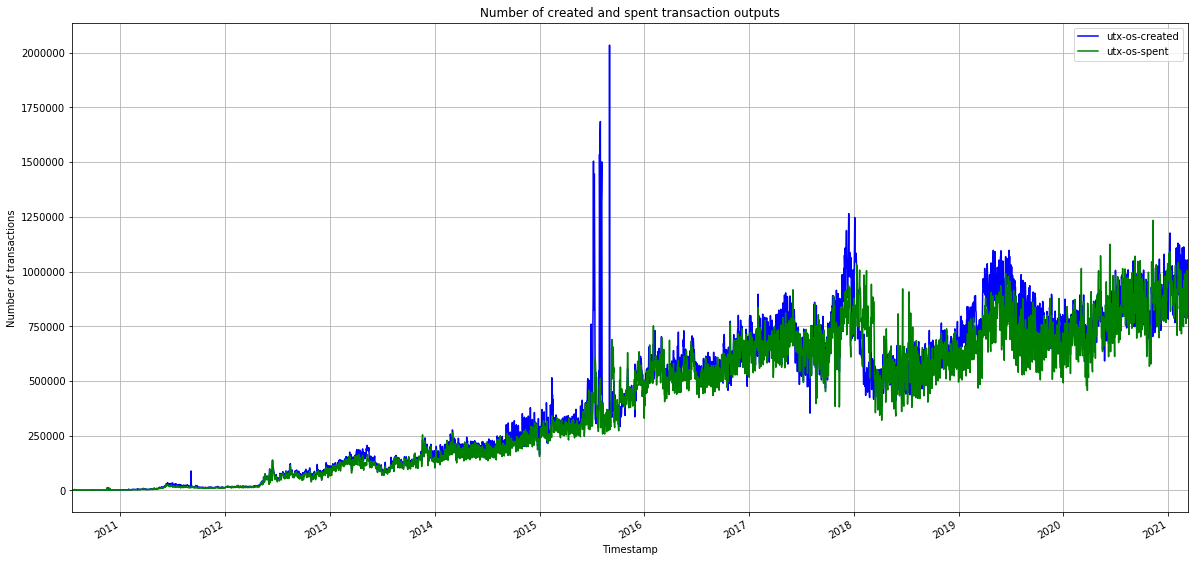

In [220]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='utx-os-created', color='blue', ax=ax)
df.plot(kind='line',y='utx-os-spent', color='green', ax=ax)
plt.title("Number of created and spent transaction outputs")
plt.ylabel("Number of transactions")
plt.grid()
plt.show()

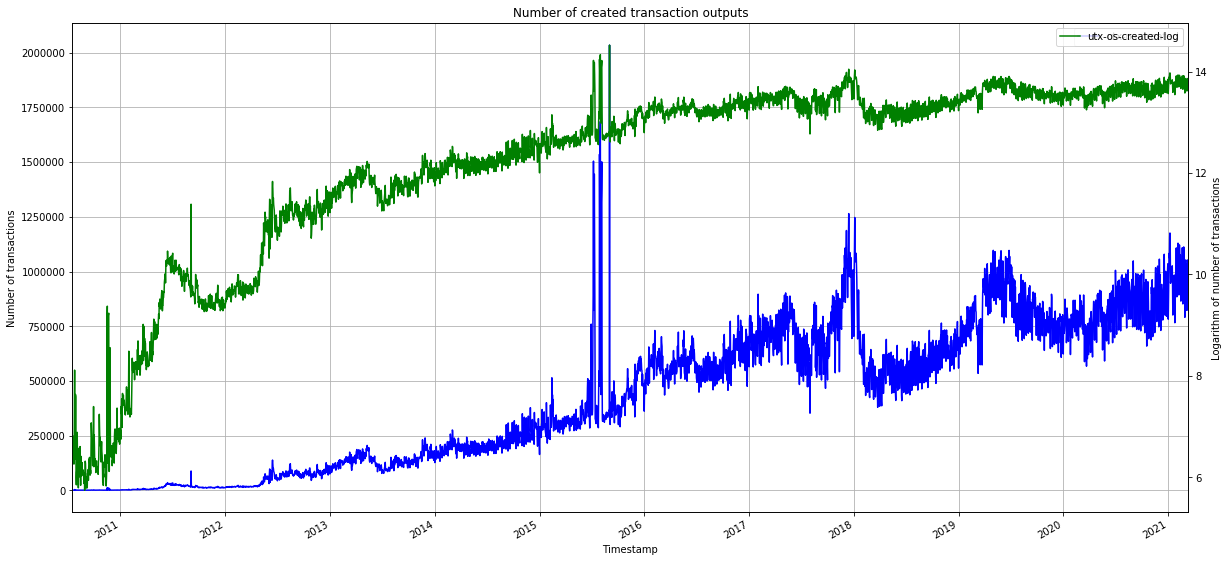

In [219]:
df['utx-os-created-log'] = np.log(df['utx-os-created'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='utx-os-created', color='blue', ax=ax)
ax_right = ax.twinx()
df.plot(kind='line',y='utx-os-created-log', color='green', ax=ax_right)
plt.title("Number of created transaction outputs")
ax.set_ylabel("Number of transactions")
ax_right.set_ylabel("Logarithm of number of transactions")
ax.grid()
plt.show()

## utxo-value-spent-mean and utxo-value-spent-median

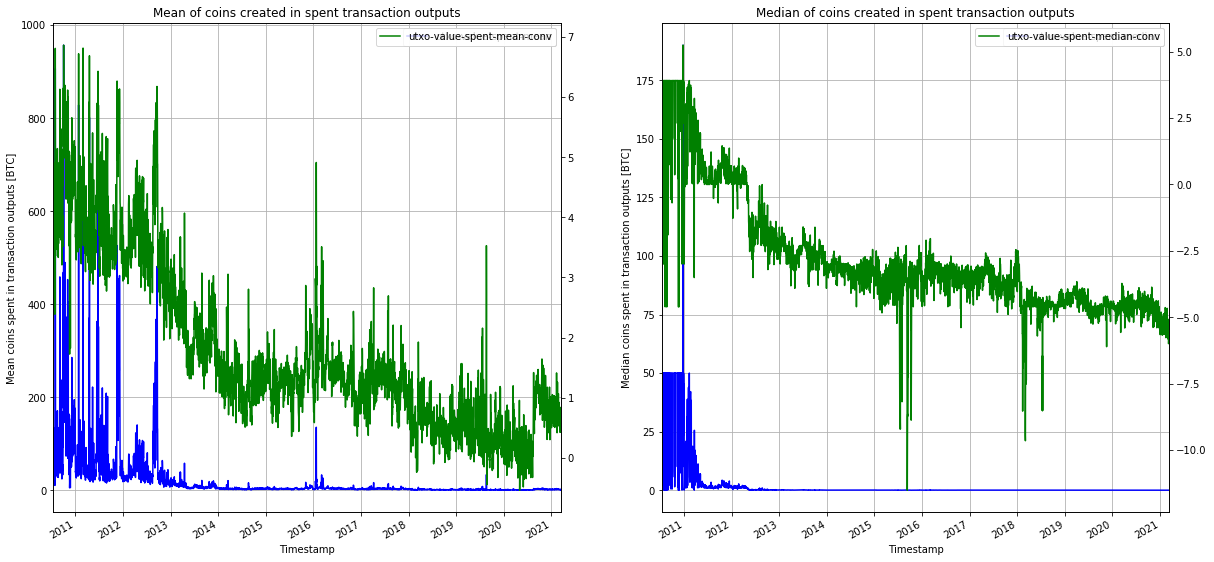

In [145]:
df['utxo-value-spent-mean-conv'] = np.log(df['utxo-value-spent-mean'])
df['utxo-value-spent-median-conv'] = np.log(df['utxo-value-spent-median'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

df.plot(kind='line',y='utxo-value-spent-mean', color='blue', ax=ax[0])
df.plot(kind='line',y='utxo-value-spent-mean-conv', color='green', ax=ax[0].twinx())

df.plot(kind='line',y='utxo-value-spent-median', color='blue', ax=ax[1])
df.plot(kind='line',y='utxo-value-spent-median-conv', color='green', ax=ax[1].twinx())

ax[0].grid()
ax[1].grid()

ax[0].set_title("Mean of coins created in spent transaction outputs")
ax[0].set_ylabel("Mean coins spent in transaction outputs [BTC]")

ax[1].set_title("Median of coins created in spent transaction outputs")
ax[1].set_ylabel("Median coins spent in transaction outputs [BTC]")

plt.show()

## utxo-value-created-mean

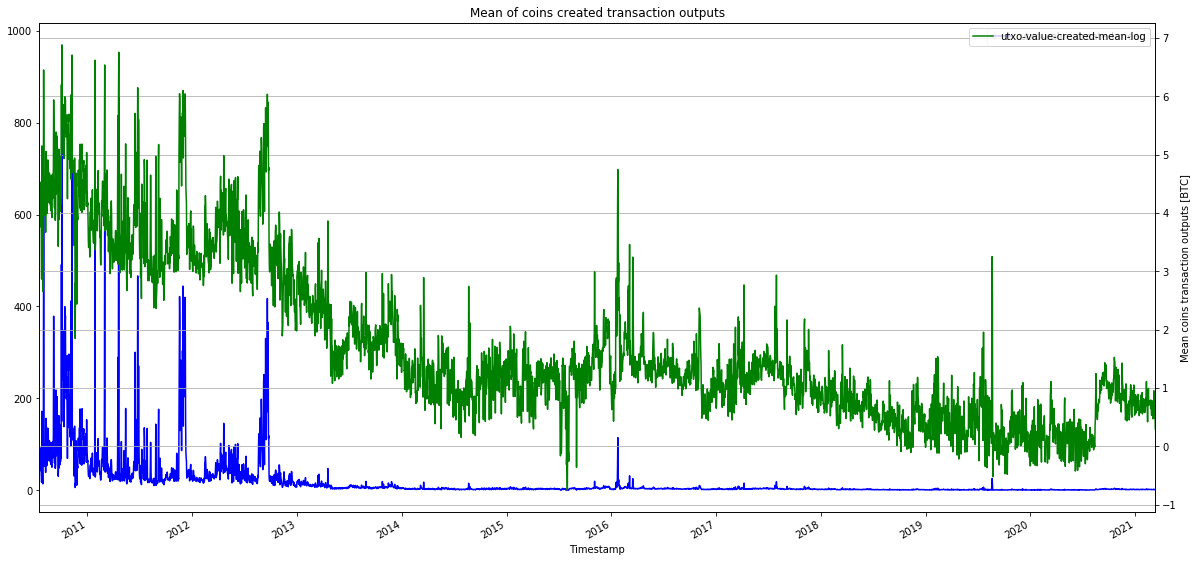

In [218]:
df['utxo-value-created-mean-log'] = np.log(df['utxo-value-created-mean'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

df.plot(kind='line',y='utxo-value-created-mean', color='blue', ax=ax)
df.plot(kind='line',y='utxo-value-created-mean-log', color='green', ax=ax.twinx())

plt.title("Mean of coins created transaction outputs")
plt.ylabel("Mean coins transaction outputs [BTC]")
plt.grid()
plt.show()